# Homework 7.2 - Coding

This is the coding portion of the homework assignment for Section 7.2

In [71]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import beta, norm, expon, logistic

---

## Problem 7.7

We look to estimate the value of the integral

$$\int_{0}^{2\pi} \frac{dx}{x^3 + x + 1}$$

using importance sampling.

Specifically, we will draw from the proposal distribution $\operatorname{Beta}(a,b)$ for various values of $a$ and $b$ until the standard error is below a suitable threshold.

To do this, write a function `integral_7_7_mc()` which estimate the value of this integral by sampling $10^6$ times from an indicated Beta distribution.

Your function should take as input:
1. A numpy random-number generator `rng`, and
2. Numerical parameters `a` and `b`, which represent the parameters of the beta distribution $\operatorname{Beta}(a,b)$, which will be the proposal distribution

Your function should return two floating-point numbers: 
1. The resulting Monte Carlo estimate for this integral, and
2. The estimated standard error

In [72]:
def integral_7_7_mc(
    rng: np.random.Generator,
    a: int | float,
    b: int | float,
) -> tuple[float | np.floating, float | np.floating]:
    """Estimates the integral in Problem 7.7 using importance sampling/Monte Carlo methods.
    
    Args:
        rng (np.random.Generator) - A numpy random number generator
            (usually generated from np.random.default_rng()). This should
            be used to sample from any distributions 
        a (int | float) - The first shape parameter of Beta(a,b) (the distribution
            that will be used to propose samples) 
        b (int | float) - The second shape parameter of Beta(a,b) (the distribution
            that will be used to propose samples) 

    Returns:
        float - The Monte Carlo estimate for this integral
        float - The approximate standard error of this approximation    
    """
    # define g(x) = 2pi * x
    # then the integral to estimate is equivalent to integral from 0 to 1 of:
    # h(x) = 2pi / ((2pi*x)^3 + 2pi*x + 1)

    # this is equal to the integral from (-inf, inf) of the indicator function from [0,1] times h(x) divided by fX(x)
    # equal to :
    # (1/n) * sum (1 to n) of that big equations, where xi comes from the draw

    n = 10**6
    samples = rng.beta(a, b, size=n)

    indicators = ((samples <= 1 )& (samples >= 0)).astype(float)
    h_of_x = (2 * np.pi) / ((2*np.pi*samples)**3 + 2*np.pi * samples + 1)
    fX_of_x = beta.pdf(samples, a, b)

    inside_summation = (indicators * h_of_x) / fX_of_x
    summation = np.sum(inside_summation)

    estimate = summation / n 

    unbiased_var = (1/(n-1)) * np.sum([(inside_summation - estimate) ** 2])

    SE = np.sqrt(unbiased_var / n)

    return estimate, SE


Experiment by running your function in the below cell for different values of $a$ and $b$ until you find values that give a standard error less than $10^{-3}$.

Once you find those values, run this cell a final time, printing to the screen your estimation, the estimated standard error, and parameters $a$ and $b$ that worked to give you this result.

In [73]:
least_se = np.inf
associated_a = 1
associated_b = 1
associated_estimate = 1

rng = np.random.default_rng()
for b in np.linspace(1, 4, 10):
    for a in np.linspace(0.5, 2, 10):
        estimate, se = integral_7_7_mc(rng, a, b)
        if se < least_se:
            least_se = se
            associated_a = a
            associated_b = b
            associated_estimate = estimate

print(f"Standard Error: {least_se}")
print(f"a: {associated_a}")
print(f"b: {associated_b}")
print(f"estimate: {associated_estimate}")

Standard Error: 0.00036826067542264395
a: 0.6666666666666666
b: 3.333333333333333
estimate: 0.9090828048937779


---

## Problem 7.9(ii)-(iii)

(Part (i) should be done in the corresponding written assignment)

First, write a function `F_inverse_logistic()` which returns the inverse of the logistic distribution c.d.f, as calculated in part (i).

Your function should take as a parameter `x`, a numpy array, and should return a numpy array of the same size consisting of the function applied to each individual element of the array.



In [74]:
def F_inverse_logistic(x: np.ndarray) -> np.ndarray:
    """The inverse of the c.d.f of the logistic distribution"""
    return -np.log((1/x) - 1)

Now, write a function `inversion_sample_logistic()` that draws from the logistic distribution using inversion sampling.

Use the function `F_inverse_logistic` which you just created while doing the inversion step.

Your function should take as input:
1. A numpy random-number generator `rng`, and
2. A desired number of samples `n`

Your function should return `n` samples from the logistic distribution as a numpy array.

In [75]:
def inversion_sample_logistic(
    rng: np.random.Generator,
    n: int
) -> np.ndarray:
    """Use inversion sampling to sample from the logistic distribution n times.
    
    Args:
        rng (np.random.Generator) - A numpy random number generator
            (usually generated from np.random.default_rng()). This should
            be used to sample from any distributions 
        n (int) - The number of samples to generate

    Returns:
        np.ndarray - An array of n samples from the logistic distribution
    """
    samples = rng.uniform(0, 1, size=n)
    return F_inverse_logistic(samples)
    

Now, using this function, in the following code cell, 

1. Sample $10^5$ ties from the logistic distribution.
2. Plot a normed histogram of the results.
3. On the *same graph*, plot the actual p.d.f of the logistic distribution
   
   (Hint: `scipy.stats.logistic` has a function `pdf` which you can use. The default parameters for "shape" and "loc" (mean) should be fine)
   
4. Add a title to your plot, and display it to the screen.

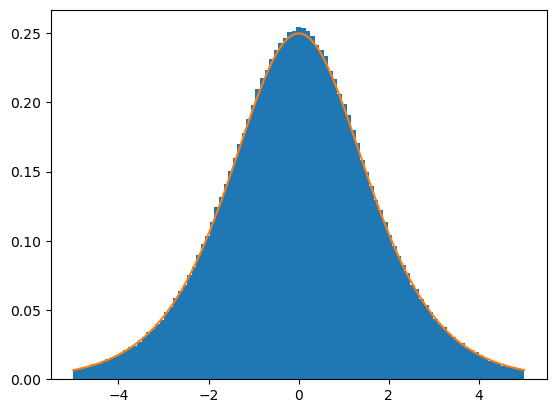

In [76]:
rng = np.random.default_rng()
n = 10**6
samples = inversion_sample_logistic(rng, n)
bins = bins=np.linspace(-5, 5, 100)
plt.hist(samples, density=True, bins=bins)
plt.plot(bins, logistic.pdf(bins, loc=0, scale=1), label = "True Distribution")
plt.show()


Finally, using the samples you generated in the previous cell, estimate the mean and variance of the distribution. 

Print these values to the screen.

In [77]:
mu_hat = np.mean(samples)
unbiased_var = (1/(n - 1))*np.sum((samples - mu_hat)**2)

print(mu_hat)
print(unbiased_var)

-8.991457160729983e-05
3.277538921333242


## Problem 7.10

Code up a function `unit_ball_volume_rejection()` which estimates the volume of the $d$-dimensional unit ball using rejection sampling.

Your function should take as input:
1. A numpy random-number generator `rng`,
2. An integer `d` representing the dimension of the unit ball whose volume we'd like to estimate, and 
3. An integer `n` representing the number of samples to use

Your function should return:
1. The estimate of the volume of this unit ball obtained via rejection-sampling, and
2. The estimated standard error of this approximation

In [78]:
def unit_ball_volume_rejection(
    rng: np.random.Generator,
    d: int,
    n: int
) -> tuple[float | np.floating, float | np.floating]:
    """Estimates the volume of the d-dimensional unit ball using rejection sampling.
    
    Args:
        rng (np.random.Generator) - A numpy random number generator
            (usually generated from np.random.default_rng()). This should
            be used to sample from any distributions 
        d (int) - The dimension of the unit ball whose volume to estimate
        n (int) - The number of samples to use
    
    Returns:
        float - The approximate volume of the d-dimensional unit ball
        float - The estimated standard error of this approximation
            """
    
    # sample all dimensions in one array
    samples = np.array(rng.uniform(-1, 1, size = n*d))

    # scan through d samples at a time, representing a point in d-dimensional space
    acceptances = np.zeros(n)
    projections = []

    for i in range(n): # iterate through each coordinate tuple index
        dist = np.linalg.norm(samples[d*i:d*i + d])
        if dist > 1: # reject
            continue
        else: # project using the first dimension
            acceptances[i] = 1
            projections.append(d*i)
    
    ratio = np.mean(acceptances)

    volume = 2**d * ratio

    unbiased_var = (1/(n-1))*np.sum((acceptances - ratio)**2)
    se = np.sqrt(unbiased_var / n)

    return volume, 2**d * se



        



Now, in the following code cell, write code that uses a set number of samples $n$ for estimating the volume of the unit ball for all $d \in \{1, 2, \ldots, 10\}$. 

Display the approximation, and the estimated standard error of each approximation, by printing it to the screen in a nice, readable way.

Repeat and experiment until you find a number of samples $n$ such that the standard error is less than $10^{-2}$ for every test case.

In [79]:
rng = np.random.default_rng()
n = 10**6
for d in np.arange(1, 11, 1):
    volume, se = unit_ball_volume_rejection(rng, d, n)
    print(f"\nd: {d}\nvolume: {volume}\nSE: {se}")



d: 1
volume: 2.0
SE: 0.0

d: 2
volume: 3.141528
SE: 0.0016422291320435534

d: 3
volume: 4.188408
SE: 0.003995562337150352

d: 4
volume: 4.93552
SE: 0.00738979140020995

d: 5
volume: 5.274784
SE: 0.011873073853186743

d: 6
volume: 5.179776
SE: 0.017454967466761808

d: 7
volume: 4.725888
SE: 0.02413669880475964

d: 8
volume: 4.032256
SE: 0.03187474648604953

d: 9
volume: 3.254784
SE: 0.04069222831169103

d: 10
volume: 2.610176
SE: 0.0516334181636166


---

IMPORTANT: Please "Restart and Run All" and ensure there are no errors. Then, submit this .ipynb file to Gradescope.